<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_ConvNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Свёрточная нейронная сеть</h1>

In [333]:
# Загрузка необходимых библиотек и функций

import sys
sys.path.append('/content')

from vkr_function import my_features_extraction, print_scores, plot_predict, my_test_train_split, my_test_val_train_split

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

try:
  from plot_keras_history import show_history, plot_history
except:
  !pip install plot_keras_history
  from plot_keras_history import show_history, plot_history

In [334]:
# Загрузка данных
Y_ = pd.read_csv('/content/flow_rate.csv')
sig_up = pd.read_csv('/content/sig_up.csv')
sig_dw = pd.read_csv('/content/sig_dw.csv')
borders = pd.read_csv('/content/borders.csv').values.tolist()[0]

In [335]:
# Подготовка данных, стандартизация, разделение на выборки

scaler = preprocessing.StandardScaler()

X_ = np.hstack([sig_up, sig_dw])
X = scaler.fit_transform(X_)
Y = np.array(Y_['Et'])
input_dim = X.shape[1]
input_dim

X_train, y_train, i_train, X_val, y_val, i_val, X_test, y_test, i_test =  my_test_val_train_split(X, Y, borders)

In [336]:
# изменение формата данных
X_train = tf.convert_to_tensor(X_train, np.float32)
X_test = tf.convert_to_tensor(X_test, np.float32)
X_val = tf.convert_to_tensor(X_val, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)
y_val = tf.convert_to_tensor(y_val, np.float32)
y_test = tf.convert_to_tensor(y_test, np.float32)

In [337]:
# Свёрточная нейронная сеть

activation_function = 'tanh'
filter_amount = 64
kz=2

model = keras.Sequential([

    layers.BatchNormalization(input_shape=(input_dim, 1)),

    layers.Conv1D(filters=filter_amount, kernel_size=kz, activation=activation_function, padding="same"),
    layers.Conv1D(filters=filter_amount, kernel_size=kz, activation=activation_function, padding="same"),
    layers.MaxPooling1D(pool_size=2, strides=2),

    layers.Conv1D(filters=filter_amount, kernel_size=kz, activation=activation_function, padding="same"),
    layers.Conv1D(filters=filter_amount, kernel_size=kz, activation=activation_function, padding="same"),
    layers.MaxPooling1D(pool_size=2, strides=2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)

    ])

In [338]:
opt = keras.optimizers.Adam() # оптимизатор

model.save_weights('model.h5') # сохранение весов

# компиляция модели
model.compile(
    optimizer=opt,
    loss='mean_squared_error',
    metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.R2Score()]
    )

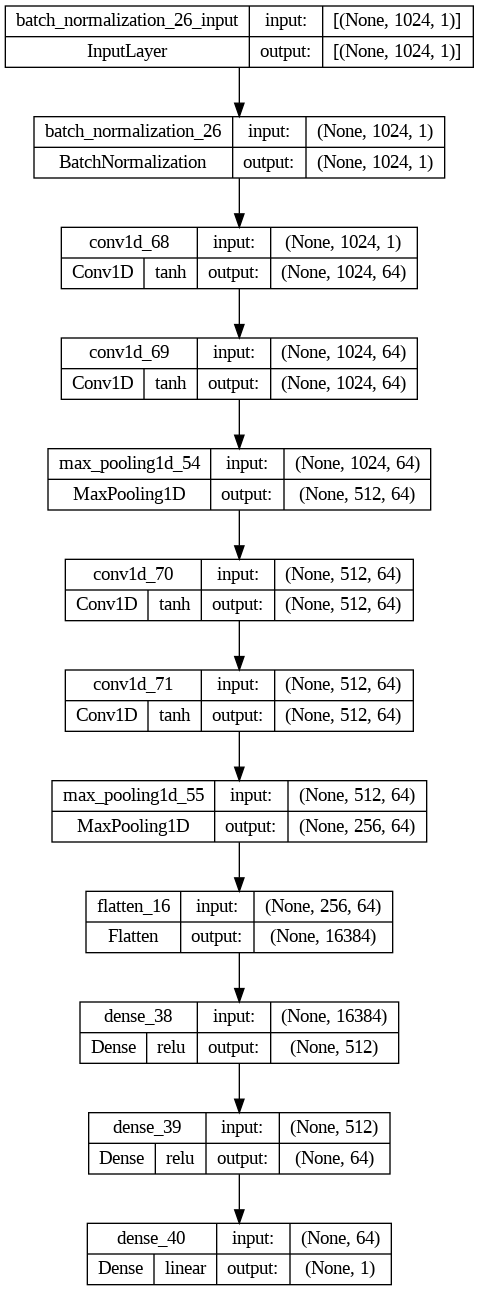

In [339]:
# вывод струтуры модели
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True,
    )

In [340]:
# класс обратного вызова
callback_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=16,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="Checkpoint_path.keras",
        nonitor="val_loss",
        save_best_only=True,
    )
]

In [341]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=64, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/64
40/40 [==============================] - 21s 471ms/step - loss: 1.8041 - root_mean_squared_error: 1.3432 - r2_score: -2.4866 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1747 - val_r2_score: 0.9410
Epoch 2/64
40/40 [==============================] - 20s 499ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - r2_score: 0.9692 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655 - val_r2_score: 0.9917
Epoch 3/64
40/40 [==============================] - 18s 448ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - r2_score: 0.9864 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721 - val_r2_score: 0.9899
Epoch 4/64
40/40 [==============================] - 21s 526ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - r2_score: 0.9884 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547 - val_r2_score: 0.9942
Epoch 5/64
40/40 [==============================] - 18s 452ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - r2_score: 0.9903 - va

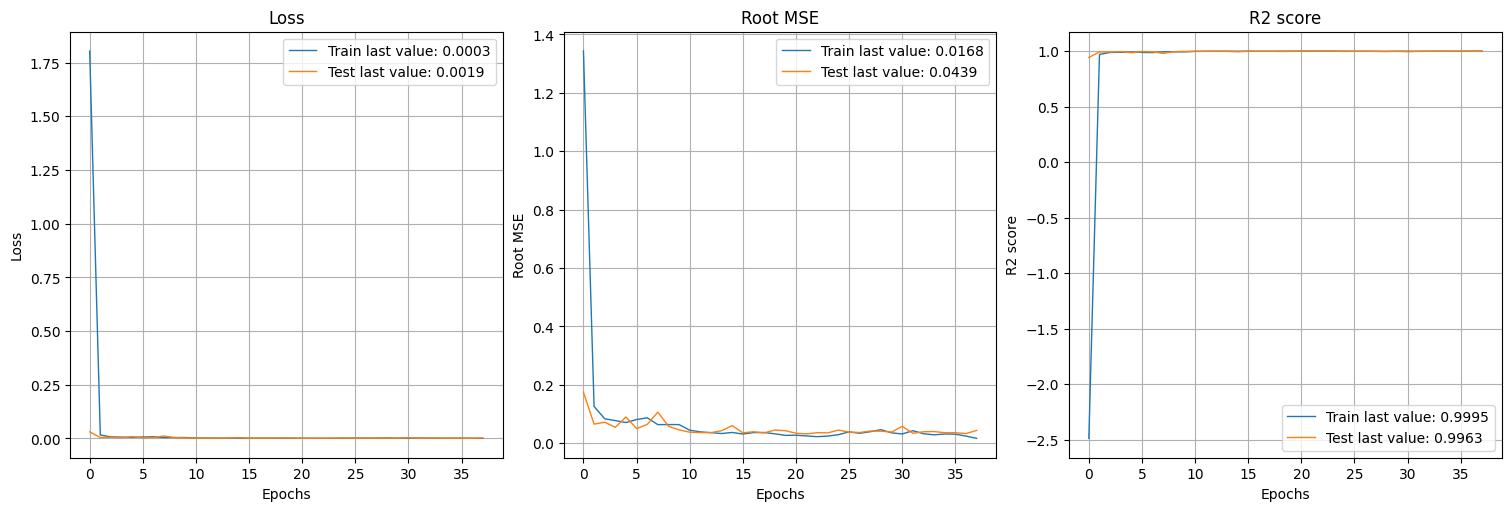

In [342]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [343]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

20/20 [==============================] - 1s 46ms/step


In [344]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 2s 81ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - r2_score: 0.9965
Валидационная выборка:
25/25 [==============================] - 2s 64ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - r2_score: 0.9963
Тренировочная выборка:
79/79 [==============================] - 4s 46ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - r2_score: 0.9976



In [345]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all, False)

123/123 [==============================] - 6s 45ms/step
Ошибка на полных данных
MSE: 0.00148
RMSE: 0.03847
R2 : 0.99714


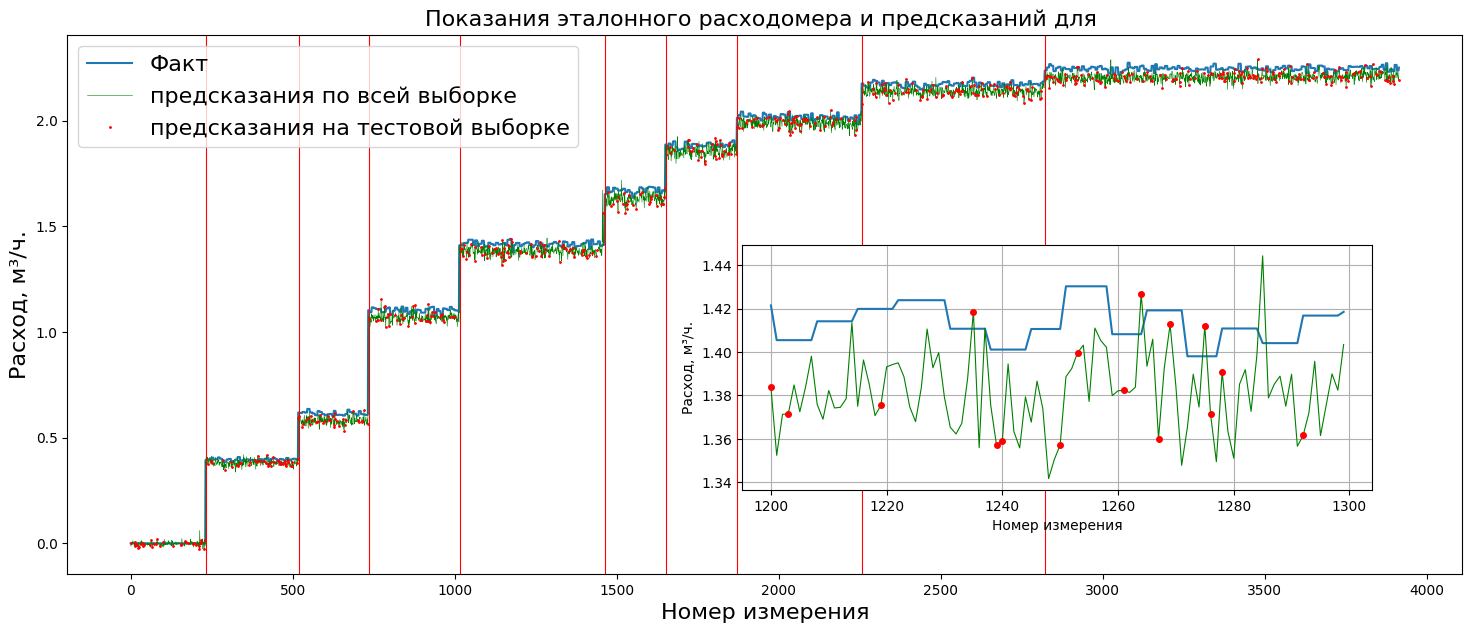

In [346]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")

<h2>Проверим работу модели, приняв за тестовую выборку один из режимов расхода</h2>

In [347]:
# Новое разделение на тестовую, валидационную и обучающую выборки

l_ = len(Y)

_, _, _, _, i_val = my_test_train_split(X, Y, borders, test_size=0.2)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)
for x2 in i_val:
  try:
    i_train.remove(x2)
  except:
    i_ = 0

for x3 in i_test:
  try:
    i_val.remove(x3)
  except:
    i_ = 0

X_train = X[i_train,:]
y_train = Y[i_train]

X_val = X[i_val,:]
y_val = Y[i_val]

X_test = X[i_test,:]
y_test = Y[i_test]


In [348]:
# сброс весов модели
model.load_weights('model.h5')

In [349]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=64, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/64
44/44 [==============================] - 20s 453ms/step - loss: 6.2595 - root_mean_squared_error: 2.5019 - r2_score: -9.8344 - val_loss: 0.4903 - val_root_mean_squared_error: 0.7002 - val_r2_score: 0.1494
Epoch 2/64
44/44 [==============================] - 21s 472ms/step - loss: 0.0968 - root_mean_squared_error: 0.3111 - r2_score: 0.8324 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882 - val_r2_score: 0.9865
Epoch 3/64
44/44 [==============================] - 21s 482ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903 - r2_score: 0.9859 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692 - val_r2_score: 0.9917
Epoch 4/64
44/44 [==============================] - 21s 468ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - r2_score: 0.9896 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571 - val_r2_score: 0.9944
Epoch 5/64
44/44 [==============================] - 19s 438ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - r2_score: 0.9885 - va

In [ ]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [350]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

15/15 [==============================] - 1s 42ms/step


In [351]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 1s 61ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - r2_score: -6.4752
Валидационная выборка:
22/22 [==============================] - 2s 83ms/step - loss: 5.6453e-04 - root_mean_squared_error: 0.0238 - r2_score: 0.9990
Тренировочная выборка:
87/87 [==============================] - 5s 52ms/step - loss: 5.0690e-04 - root_mean_squared_error: 0.0225 - r2_score: 0.9991



In [352]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all, False)

123/123 [==============================] - 6s 50ms/step
Ошибка на полных данных
MSE: 0.00068
RMSE: 0.02611
R2 : 0.99868


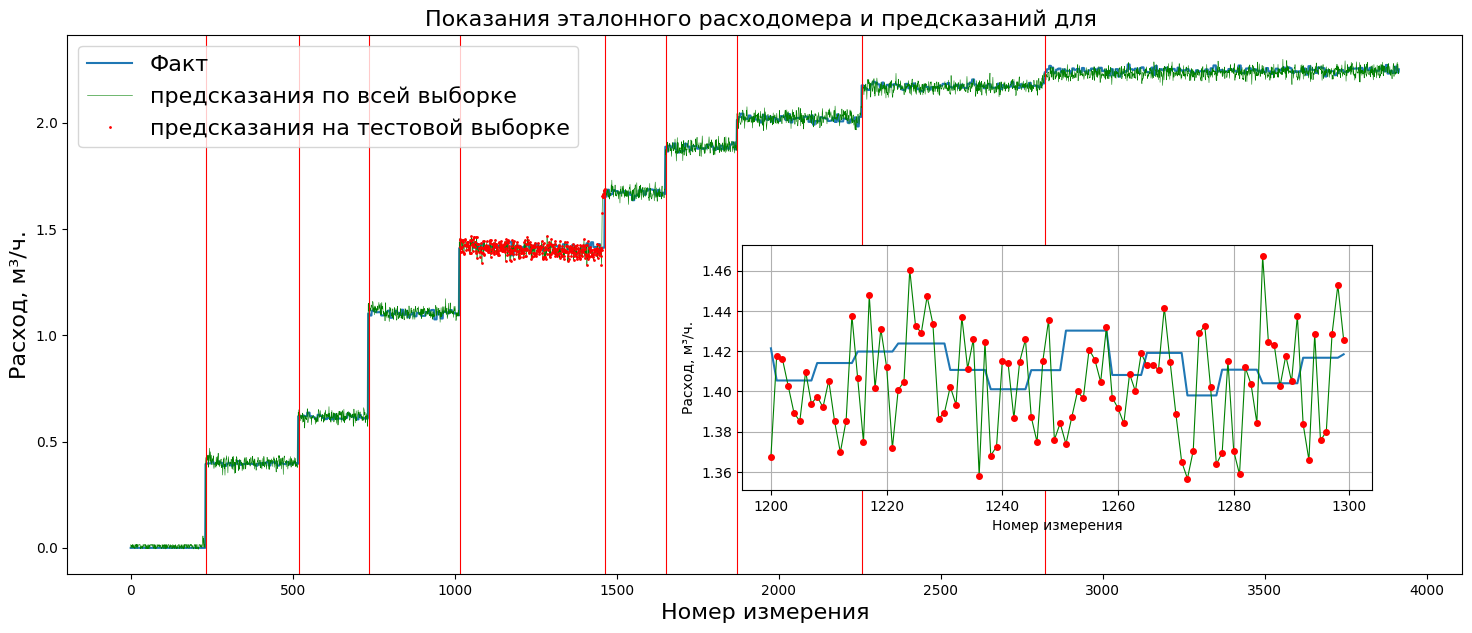

In [353]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")